# ORENIST Convolutional Filter Example

**Note**: This notebook is designed to run on CPU (no GPU) runtime.

**[OCF-01]**

Install libraries.

In [ ]:
%%bash
curl -sLO https://raw.githubusercontent.com/enakai00/colab_jaxbook/main/requirements.txt
pip install -qr requirements.txt
pip list | grep -E '(jax|flax|optax)'

flax                          0.6.1
jax                           0.3.21
jaxlib                        0.3.15+cuda11.cudnn805
optax                         0.1.3


**[OCF-02]**

Import modules.

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.core.frozen_dict import freeze, unfreeze

plt.rcParams.update({'font.size': 12})

**[OCF-03]**

Download ORENIST dataset and convert to DeviceArray objects.

In [ ]:
!curl -LO https://github.com/enakai00/colab_jaxbook/raw/main/Chapter04/ORENIST.pkl
with open('ORENIST.pkl', 'rb') as file:
    images, labels = pickle.load(file)
images = jnp.asarray(images)
labels = jnp.asarray(labels)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  553k  100  553k    0     0  1032k      0 --:--:-- --:--:-- --:--:-- 1797k


**[OCF-04]**

Show sample images.

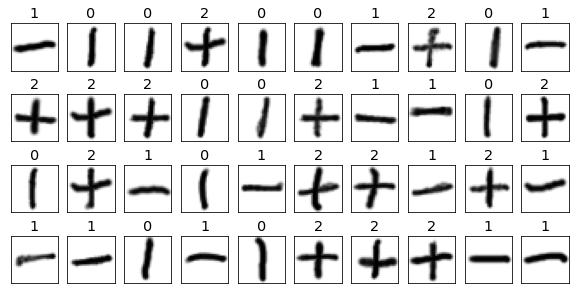

In [ ]:
fig = plt.figure(figsize=(10, 5))
for i in range(40):
    subplot = fig.add_subplot(4, 10, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)

**[OCF-05]**

Prepare the fixed convolutional filters and store them in `filter_array`.

In [ ]:
filter0 = np.array([[ 2, 1, 0,-1,-2],
                    [ 3, 2, 0,-2,-3],
                    [ 4, 3, 0,-3,-4],
                    [ 3, 2, 0,-2,-3],
                    [ 2, 1, 0,-1,-2]]) / 23.0
filter1 = np.array([[ 2, 3, 4, 3, 2],
                    [ 1, 2, 3, 2, 1],
                    [ 0, 0, 0, 0, 0],
                    [-1,-2,-3,-2,-1],
                    [-2,-3,-4,-3,-2]]) / 23.0

filter_array = np.zeros([5, 5, 1, 2])
filter_array[:, :, 0, 0] = filter0
filter_array[:, :, 0, 1] = filter1

**[OCF-06]**

Define a model to apply the fixed convolutional filters.

In [ ]:
class FixedConvFilterModel(nn.Module):
    @nn.compact
    def __call__(self, x, apply_pooling=False):
        x = x.reshape([-1, 28, 28, 1])
        x = nn.Conv(features=2, kernel_size=(5, 5), use_bias=False)(x)
        x = jnp.abs(x)
        x = nn.relu(x-0.2)
        if apply_pooling:
            x = nn.max_pool(x, window_shape=(2, 2), strides=(2, 2))
        return x

**[OCF-07]**

Generate initial parameter values.

In [ ]:
key, key1 = random.split(random.PRNGKey(0))
variables = FixedConvFilterModel().init(key1, images[0:1])

jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    Conv_0: {
        kernel: (5, 5, 1, 2),
    },
})

**[OCF-08]**

Update parameter values with the fixed convolutional filters, and create a TrainState object with the new parameter values.

In [ ]:
params = unfreeze(variables['params'])
params['Conv_0']['kernel'] = jnp.asarray(filter_array)
new_params = freeze(params)

state = train_state.TrainState.create(
    apply_fn=FixedConvFilterModel().apply,
    params=new_params,
    tx=optax.adam(learning_rate=0.001))

**[OCF-09]**

Show images after applying the convolutional filters.

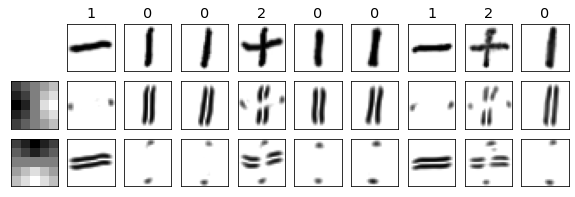

In [ ]:
conv_output = jax.device_get(
    state.apply_fn({'params': state.params}, images[:9]))
filter_vals = jax.device_get(state.params['Conv_0']['kernel'])

fig = plt.figure(figsize=(10, 3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

v_max = np.max(conv_output)
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(conv_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)

**[OCF-10]**

Show images after applying the convolutional filters and the pooling layer.

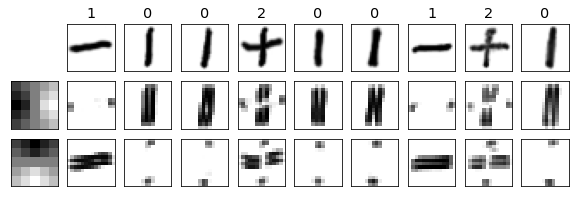

In [ ]:
pool_output = jax.device_get(
    state.apply_fn({'params': state.params}, images[:9], apply_pooling=True))
filter_vals = jax.device_get(state.params['Conv_0']['kernel'])

fig = plt.figure(figsize=(10, 3))

for i in range(2):
    subplot = fig.add_subplot(3, 10, 10*(i+1)+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(filter_vals[:, :, 0, i], cmap=plt.cm.gray_r)

v_max = np.max(conv_output)
for i in range(9):
    subplot = fig.add_subplot(3, 10, i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.set_title(np.argmax(labels[i]))
    subplot.imshow(images[i].reshape([28, 28]),
                   vmin=0, vmax=1, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 10+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 0],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)
    
    subplot = fig.add_subplot(3, 10, 20+i+2)
    subplot.set_xticks([])
    subplot.set_yticks([])
    subplot.imshow(pool_output[i, :, :, 1],
                   vmin=0, vmax=v_max, cmap=plt.cm.gray_r)